<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/Keras-Tensorflow-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras-Tensorflow Experiments


##### Sources:
 + https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
 + https://www.kaggle.com/grafiszti/98-59-acc-on-10-fold-with-testing-7-keras-models
 + https://keras.io/visualization/
 + https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

## Initial Setup

### Include needed files. 

In [60]:
from __future__ import absolute_import, division, print_function, unicode_literals

import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

import csv
import os
import sys
import glob
import operator
import time

import seaborn as sn

import matplotlib.pyplot as plt

from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical, normalize

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

1.14.0


### Include Dataset






In [0]:
%%bash
URL=https://iscxdownloads.cs.unb.ca/iscxdownloads/ISCX-URL-2016/
FILES=(ISCXURL2016.zip) 
for FILE in ${FILES[*]}; do
    if [ ! -f "$FILE" ]; then
        printf "downloading %s\n" $FILE
        curl -O $URL$FILE
        # unzip files
        echo 'unzipping ' $FILE
        unzip -o $FILE #overwrite exiting files/folders if exists
    fi
done

### Check Dataset

In [62]:
! ls FinalDataset

All_BestFirst.csv	      Malware_Infogain.csv
All_BestFirst_test.csv	      Malware_Infogain_test.csv
All.csv			      Phishing_BestFirst.csv
All.csv.pickle		      Phishing.csv
All_Infogain.csv	      Phishing_Infogain.csv
All_Infogain_test.csv	      Phishing_Infogain_test.csv
Defacement_BestFirst.csv      Spam_BestFirst.csv
Defacement.csv		      Spam_BestFirst_test.csv
Defacement_Infogain.csv       Spam.csv
Defacement_Infogain_test.csv  Spam_Infogain.csv
Malware_BestFirst.csv	      Spam_Infogain_test.csv
Malware.csv		      URL


### Set some data
> Some data needs to be set, we need to ensure that constants are set properly. These are important but will not be used until later.

In [0]:
resultPath = 'results_keras_tensorflow'
if not os.path.exists(resultPath):
   print('result path {} created.'.format(resultPath))
   os.mkdir(resultPath)

In [0]:
model_name = "init"

## Functions for Testing
> Now that our data has been collected it is time to create functions that will be used in later tests.

In [0]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False, na_values='NaN')
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        df.to_pickle(pickleDump)
    
    return df


In [0]:
def baseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dropout(.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(outputDim, activation='softmax')
    ]) #This is the output layer

    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function')
        model_extension = "_categorical"
        experimentTitle = "Categorical"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Function')
        model_extension = "_binary"
        experimentTitle = "Binary"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

In [0]:
def encode_labels(dataframe):
    dataframe=dataframe.copy()
    data_y=dataframe.pop(dep_var)
    encoder = LabelEncoder()
    encoder.fit(data_y)
    data_y = encoder.transform(data_y)
    dummy_y = to_categorical(data_y)
    return dummy_y

In [0]:
def plotAccuracy(title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
def plotLoss(title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
def plot_Experiment(history,y):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,y])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,y])
  plt.legend()
  plt.show()

In [0]:
# Function to determine train and validation indexes, 
# and fit the data to the model we constructed
def experiment(dataframe, early=False):
    
    #10-fold cross validation, choosing random indices for training and validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Encode the label column for model fitting
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    
    # X is our data/features to train the model with
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    
    # Y is our labels to classify the data
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()

    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]

        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))

        model = baseline_model(inputDim,outputDim)
        
        time_gen = int(time.time())
        
        global model_name
        model_name = f"{dataFile}_{time_gen}"

        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard, early_stop]
        else:
            callbacks = [tensorboard]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)
        
    global end_time 
    end_time = time.time() - start_time
    TimeSetup = str(datetime.timedelta(seconds=end_time))
    Minutes = int(end_time/60)
    print("Time to complete {} [hour:min:sec]".format(TimeSetup)) 
        
    return model, history, X, encoded_y, TimeSetup


## Data
### Load and Clean
> First we will load our data, scan the columns for Infinity and NaN values, and remove those columns from testing. 

In [0]:
df1 = loadData('FinalDataset/All.csv')
df1=df1.dropna(axis=1)

### Display Data Columns

In [73]:
df1.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'tld', 'charcompvowels',
       'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 'ldl_filename',
       'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path', 'dld_filename',
       'dld_getArg', 'urlLen', 'domainlength', 'pathLength', 'subDirLen',
       'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathTokenLength',
       'Do

### Display Matrix Shape of Data
> In the format (samples, columns)

In [74]:
df1.shape

(36697, 73)

### Display First Samples in Data

In [75]:
df1.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
0,0,4,5,5.5,14,4,8,3,0,0,0,0,0,0,0,0,0,0,58,25,26,26,13,1,2,0.448276,0.034483,0.08,0.431034,1.04,0.07692308,0,-1,5,-1,0.6,-1,1,0,0,0,1,-1,47,22,8,13,0,-1,13,14,13,5,-1,0,0,3,0,2,-1,0.017241,0.0,0.0,0.066667,8,3,2,1,0,-1,0.726298,0.784493,Defacement
1,0,4,5,5.5,14,4,12,4,0,0,0,0,0,0,0,0,0,0,66,25,34,34,2,2,2,0.515151,0.030303,0.08,0.378788,1.36,0.05882353,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,56,22,8,13,9,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.688635,0.784493,Defacement
2,0,4,5,5.5,14,4,12,5,0,0,0,0,0,0,0,0,0,0,65,25,33,33,2,2,2,0.507692,0.030769,0.08,0.384615,1.32,0.060606062,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,55,22,8,13,8,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.695049,0.784493,Defacement
3,0,4,12,5.5,14,4,32,16,0,0,0,0,0,0,0,0,0,0,109,25,77,77,2,2,2,0.706422,0.018349,0.08,0.229358,3.08,0.025974026,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,92,22,8,13,45,-1,52,14,13,13,-1,0,0,4,0,8,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.640130,0.784493,Defacement
4,0,4,6,5.5,14,4,18,11,0,0,0,0,0,0,0,0,0,0,81,25,49,49,2,2,2,0.604938,0.024691,0.08,0.308642,1.96,0.040816326,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,70,22,8,13,23,-1,24,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.681307,0.784493,Defacement


### Display Last Samples in Data

In [76]:
df1.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
36702,29,4,14,5.750000,12,4,20,24,3,0,3,0,2,0,0,0,0,0,146,26,113,113,2,2,85,0.773973,0.582192,3.269231,0.178082,4.346154,0.7522124,0,-1,5,-1,0.500000,23,31,0,4,0,27,3,94,23,46,7,14,24,43,12,11,11,23,0,3,6,0,2,5,0.212329,0.0,0.064516,0.529412,19,3,11,3,2,7,0.690555,0.791265,spam
36703,0,4,13,3.750000,8,4,24,23,0,0,0,0,0,0,0,0,0,0,147,18,122,122,2,2,2,0.829932,0.013605,0.111111,0.122449,6.777778,0.016393442,0,-1,5,-1,0.500000,-1,21,0,0,0,21,-1,101,15,7,6,69,-1,105,8,9,9,-1,0,0,3,0,2,-1,0.142857,0.0,0.000000,0.187500,23,3,2,16,15,-1,0.665492,0.820010,spam
36704,58,3,27,6.666666,16,3,41,34,20,0,20,0,18,12,0,12,0,12,246,22,217,217,2,2,182,0.882114,0.739837,8.272727,0.089431,9.863636,0.83870965,0,-1,7,-1,0.772727,58,57,0,6,0,51,1,156,20,71,3,58,48,118,16,12,12,0,0,1,12,0,9,1,0.231707,0.0,0.073171,0.377778,26,2,14,8,7,9,0.656807,0.801139,spam
36705,35,3,13,4.333334,9,3,15,13,7,0,7,0,7,4,0,4,0,4,116,15,94,94,2,2,71,0.810345,0.612069,4.733333,0.129310,6.266667,0.7553192,0,-1,3,-1,0.666667,32,25,0,0,0,25,23,73,13,4,11,41,12,75,9,8,8,0,0,2,3,0,3,3,0.215517,0.0,0.000000,0.284091,14,2,1,9,8,3,0.725963,0.897617,spam
36706,40,3,25,6.666666,16,3,35,31,19,0,19,0,17,6,0,6,0,6,227,22,198,198,2,2,164,0.872247,0.722467,7.454546,0.096916,9.000000,0.82828283,0,-1,6,-1,0.772727,40,52,0,6,1,45,2,144,20,50,6,64,31,118,16,10,10,0,0,1,11,0,8,1,0.229075,0.0,0.083333,0.365079,24,2,13,7,6,7,0.674351,0.801139,spam


  ## Experimenting with Final Dataset/All.csv
  
  #### Total Samples for each Type

In [77]:
label = 'URL_Type_obf_Type'
lblTypes=set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| Defacement | 7930 |
| phishing | 7577 |
| malware | 6711 |
| spam | 6698 |
| benign | 7781 |


In [0]:
dataPath = 'FinalDataset'
dep_var = label

### Cast column values to float
> Values in this column register as object type, which isn't valid for testing, so cast them to float

In [0]:
df1.argPathRatio = df1['argPathRatio'].astype('float')

## Experimenting with Tensorflow Keras

#### Globals for Testing


In [0]:
dataFile = 'All.csv'
epochs=100
batch_size=64

#### Show uncoded label column

In [81]:
df1[dep_var]

0        Defacement
1        Defacement
2        Defacement
3        Defacement
4        Defacement
5        Defacement
6        Defacement
7        Defacement
8        Defacement
9        Defacement
10       Defacement
11       Defacement
12       Defacement
13       Defacement
14       Defacement
15       Defacement
16       Defacement
17       Defacement
18       Defacement
19       Defacement
20       Defacement
21       Defacement
22       Defacement
23       Defacement
24       Defacement
25       Defacement
26       Defacement
27       Defacement
28       Defacement
29       Defacement
            ...    
36677          spam
36678          spam
36679          spam
36680          spam
36681          spam
36682          spam
36683          spam
36684          spam
36685          spam
36686          spam
36687          spam
36688          spam
36689          spam
36690          spam
36691          spam
36692          spam
36693          spam
36694          spam
36695          spam


#### Random seed for splitting

In [0]:
seed = 7
np.random.seed(seed)

In [0]:
for file in glob.glob('keras_tensorflow_logs/Categorical*'):
        if os.path.exists(file):
            shutil.rmtree(file)
for file in glob.glob('keras_tensorflow_logs/Binary*'):
    if os.path.exists(file):
        shutil.rmtree(file)

### Overfitting and Underfitting
We need to test the best way to avoid over/under-fitting. 

1. I want to setup an early stop using the Keras Function
2. I want to give the models a full train to see overfitting/underfitting results for the base model.
2. I will test Early Stop to prevent underfitting
3. I will test Weight Regularization
4. I will test a dropout

> our goal is to train quickly and efficiently. 

In [0]:
#Constants for this
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
import datetime


* We will use the function experiment and edit it until the model is properly fitted.

####  Model Creation steps
1. Create a model with no changes
2. Add the Early Stop
3. test Dropout
4. Test weight regularization
5. Results


##### BaseLine test 1

In [0]:
def TESTbaseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(outputDim, activation='softmax')
    ]) #This is the output layer

    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function')
        model_extension = "_categorical"
        experimentTitle = "Categorical"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Function')
        model_extension = "_binary"
        experimentTitle = "Binary"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model
def BaseLine_experiment(dataframe, early=False):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()
    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]
        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))
        model = TESTbaseline_model(inputDim,outputDim)    
        time_gen = int(time.time())        
        global model_name
        model_name = f"{dataFile}_{time_gen}"
        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard]
        else:
            callbacks = [tensorboard]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)        
    global end_time 
    end_time = time.time() - start_time
    TimeSetup = str(datetime.timedelta(seconds=end_time))
    Minutes = int(end_time/60)
    print("Time to complete {} [hour:min:sec]".format(TimeSetup))    
    return model, history, X, encoded_y

Running fold #1
Categorical Cross-Entropy Loss Function
Running fold #2
Categorical Cross-Entropy Loss Function
Running fold #3
Categorical Cross-Entropy Loss Function
Running fold #4
Categorical Cross-Entropy Loss Function
Running fold #5
Categorical Cross-Entropy Loss Function
Running fold #6
Categorical Cross-Entropy Loss Function
Running fold #7
Categorical Cross-Entropy Loss Function
Running fold #8
Categorical Cross-Entropy Loss Function
Running fold #9
Categorical Cross-Entropy Loss Function
Running fold #10
Categorical Cross-Entropy Loss Function
Time to complete 0:26:02.112721 [hour:min:sec]


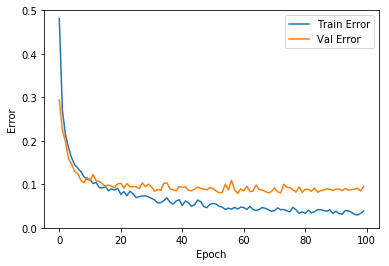

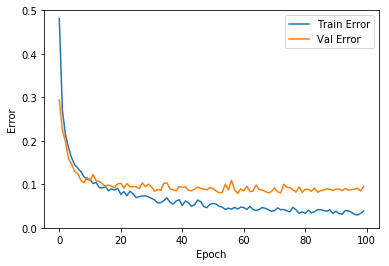

In [86]:
categorical_df = df1.copy()
modelBL, BLhistory, BLX , BLencoded_y = BaseLine_experiment(categorical_df,early=True)
plot_Experiment(BLhistory,.5)

In [87]:
scores = modelBL.evaluate(BLX,BLencoded_y, batch_size=batch_size,verbose=1)
print(modelBL.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 1s 27us/sample - loss: 0.0261 - acc: 0.9920
['loss', 'acc']
Baseline: accuracy: 99.20%: loss: 0.03


##### Early Stop Implementation. 

In [0]:
def ESexperiment(dataframe, early=False):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()
    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]
        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))
        model = TESTbaseline_model(inputDim,outputDim)    
        time_gen = int(time.time())        
        global model_name
        model_name = f"{dataFile}_{time_gen}"
        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard,early_stop]
        else:
            callbacks = [tensorboard, early_stop]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)        
    global end_time 
    end_time = time.time() - start_time
    TimeSetup = str(datetime.timedelta(seconds=end_time))
    Minutes = int(end_time/60)
    print("Time to complete {} [hour:min:sec]".format(TimeSetup))    
    return model, history, X, encoded_y

In [89]:
categorical_df = df1.copy()
modelES, EShistory, ESX , ESencoded_y = ESexperiment(categorical_df,early=True)

Running fold #1
Categorical Cross-Entropy Loss Function
Running fold #2
Categorical Cross-Entropy Loss Function
Running fold #3
Categorical Cross-Entropy Loss Function
Running fold #4
Categorical Cross-Entropy Loss Function
Running fold #5
Categorical Cross-Entropy Loss Function
Running fold #6
Categorical Cross-Entropy Loss Function
Running fold #7
Categorical Cross-Entropy Loss Function
Running fold #8
Categorical Cross-Entropy Loss Function
Running fold #9
Categorical Cross-Entropy Loss Function
Running fold #10
Categorical Cross-Entropy Loss Function
Time to complete 0:10:33.528763 [hour:min:sec]


In [0]:
plot_Experiment(EShistory,.5)

In [91]:
scores = modelES.evaluate(ESX,ESencoded_y, batch_size=batch_size,verbose=1)
print(modelES.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 1s 32us/sample - loss: 0.0558 - acc: 0.9838
['loss', 'acc']
Baseline: accuracy: 98.38%: loss: 0.06


##### Add Dropout

In [0]:
def Dropoutbaseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dropout(.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(outputDim, activation='softmax')
    ]) #This is the output layer

    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function')
        model_extension = "_categorical"
        experimentTitle = "Categorical"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Function')
        model_extension = "_binary"
        experimentTitle = "Binary"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
def DPexperiment(dataframe, early=False):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()
    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]
        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))
        model = TESTbaseline_model(inputDim,outputDim)    
        time_gen = int(time.time())        
        global model_name
        model_name = f"{dataFile}_{time_gen}"
        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard,early_stop]
        else:
            callbacks = [tensorboard, early_stop]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)        
    global end_time 
    end_time = time.time() - start_time
    TimeSetup = str(datetime.timedelta(seconds=end_time))
    Minutes = int(end_time/60)
    print("Time to complete {} [hour:min:sec]".format(TimeSetup))    
    return model, history, X, encoded_y

In [93]:
categorical_df = df1.copy()
modelDropout, DropOuthistory, DPX , DPencoded_y = DPexperiment(categorical_df,early=True)

Running fold #1
Categorical Cross-Entropy Loss Function
Running fold #2
Categorical Cross-Entropy Loss Function
Running fold #3
Categorical Cross-Entropy Loss Function
Running fold #4
Categorical Cross-Entropy Loss Function
Running fold #5
Categorical Cross-Entropy Loss Function
Running fold #6
Categorical Cross-Entropy Loss Function
Running fold #7
Categorical Cross-Entropy Loss Function
Running fold #8
Categorical Cross-Entropy Loss Function
Running fold #9
Categorical Cross-Entropy Loss Function
Running fold #10
Categorical Cross-Entropy Loss Function
Time to complete 0:15:23.401620 [hour:min:sec]


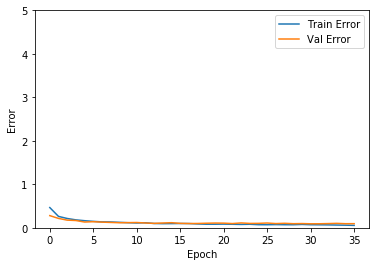

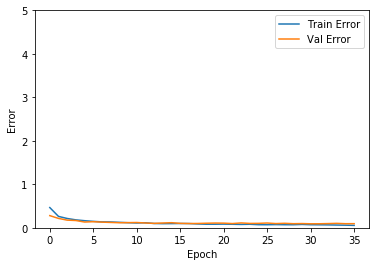

In [95]:
 
plot_Experiment(DropOuthistory,5)

In [96]:
scores = modelDropout.evaluate(DPX,DPencoded_y, batch_size=batch_size,verbose=1)
print(modelDropout.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 1s 37us/sample - loss: 0.0426 - acc: 0.9862
['loss', 'acc']
Baseline: accuracy: 98.62%: loss: 0.04


##### Add weight regularization

In [0]:
def Regularize_Model(inputDim=-1,outputDim=-1):
  global model_extensionR, Experiment_TitleR
  model = tf.keras.Sequential([
        Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu',input_shape=(inputDim,)),
        BatchNormalization(),
        Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dense(outputDim, activation='softmax')
    ])
  if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function')
        model_extension = "_categorical"
        experimentTitle = "Categorical"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
  else:
      print('Binary Cross-Entropy Loss Function')
      model_extension = "_binary"
      experimentTitle = "Binary"
      model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model
  

In [0]:
def L2experiment(dataframe, early=False):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()
    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]
        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))
        model = Regularize_Model(inputDim,outputDim)    
        time_gen = int(time.time())        
        global model_name
        model_name = f"{dataFile}_{time_gen}"
        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard,early_stop]
        else:
            callbacks = [tensorboard, early_stop]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)        
    global end_time 
    end_time = time.time() - start_time
    TimeSetup = str(datetime.timedelta(seconds=end_time))
    Minutes = int(end_time/60)
    print("Time to complete {} [hour:min:sec]".format(TimeSetup))    
    return model, history, X, encoded_y

In [99]:
categorical_df = df1.copy()
modelReg, Reghistory, RegX , Regencoded_y = L2experiment(categorical_df,early=True)

Running fold #1
Categorical Cross-Entropy Loss Function
Running fold #2
Categorical Cross-Entropy Loss Function
Running fold #3
Categorical Cross-Entropy Loss Function
Running fold #4
Categorical Cross-Entropy Loss Function
Running fold #5
Categorical Cross-Entropy Loss Function
Running fold #6
Categorical Cross-Entropy Loss Function
Running fold #7
Categorical Cross-Entropy Loss Function
Running fold #8
Categorical Cross-Entropy Loss Function
Running fold #9
Categorical Cross-Entropy Loss Function
Running fold #10
Categorical Cross-Entropy Loss Function
Time to complete 0:12:03.167546 [hour:min:sec]


In [100]:
scores = modelReg.evaluate(RegX,Regencoded_y, batch_size=batch_size,verbose=1)
print(modelReg.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 2s 43us/sample - loss: 0.1510 - acc: 0.9713
['loss', 'acc']
Baseline: accuracy: 97.13%: loss: 0.15


##### Save Models

In [0]:
modelReg.save('{}.model'.format("Regularization"))
modelDropout.save('{}.model'.format("DropOut"))
modelES.save('{}.model'.format("Early_Stop"))
modelBL.save('{}.model'.format("Base_Line"))

### Run the experiment

In [114]:
categorical_df = df1.copy()
model, history, X , encoded_y, tTime = experiment(categorical_df,early=True)

Running fold #1
Categorical Cross-Entropy Loss Function
Running fold #2
Categorical Cross-Entropy Loss Function
Running fold #3
Categorical Cross-Entropy Loss Function
Running fold #4
Categorical Cross-Entropy Loss Function
Running fold #5
Categorical Cross-Entropy Loss Function
Running fold #6
Categorical Cross-Entropy Loss Function
Running fold #7
Categorical Cross-Entropy Loss Function
Running fold #8
Categorical Cross-Entropy Loss Function
Running fold #9
Categorical Cross-Entropy Loss Function
Running fold #10
Categorical Cross-Entropy Loss Function
Time to complete 0:32:34.088277 [hour:min:sec]


#### Save the model as a file

In [0]:
model.save('{}.model'.format(os.path.basename(dataPath)))

### Model Results

In [104]:
scores = model.evaluate(X,encoded_y, batch_size=batch_size,verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 2s 45us/sample - loss: 0.1322 - acc: 0.9553
['loss', 'acc']
Baseline: accuracy: 95.53%: loss: 0.13


#### Generate predictions from the model

In [105]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

36697/36697 [==============================] - 3s 72us/sample


#### Confusion Matrix

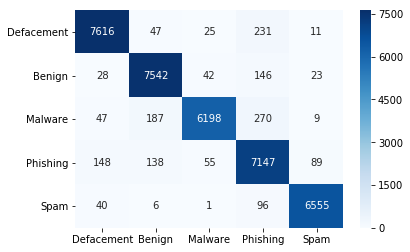

In [106]:
y=LabelEncoder().fit_transform(categorical_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
           yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])

#### Graph of Categorical Cross-Entropy Model

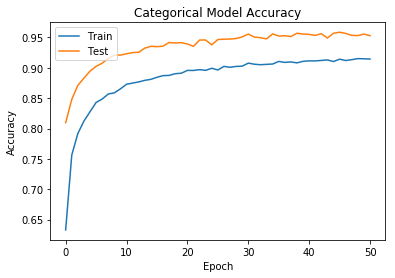

In [107]:
plotAccuracy('Categorical Model Accuracy')

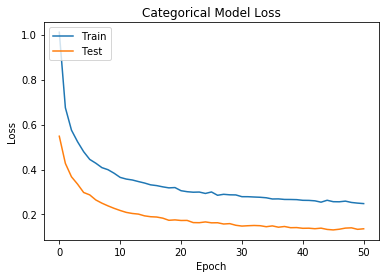

In [108]:
plotLoss('Categorical Model Loss')

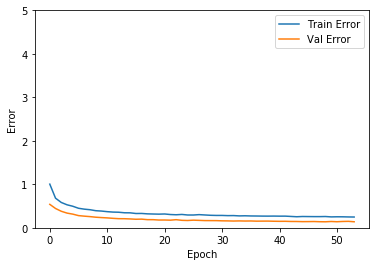

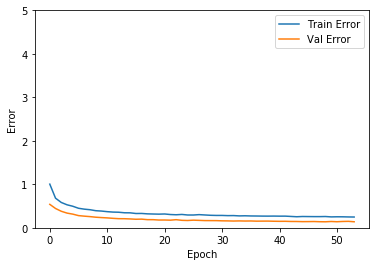

In [117]:
plot_Experiment(history, 5)

### Write results to file

In [0]:

def saveLog():
    resultFile = os.path.join(resultPath, dataFile)
    with open('{}.result'.format(resultFile), 'a') as fout:
        fout.write('{} results...'.format(model_name+model_extension))
        fout.write('\taccuracy: {:.2f} loss: {:.2f} time_elapsed: {} [hr:min:sec] \n'.format(acc, loss,tTime ))

In [0]:
saveLog()

## Binary Classification of Labels
> Change all malicious labels to value 1 and benign label to 0

### Binarize Data

In [0]:
lblTypes = list(lblTypes)
lblTypes = dict(zip(lblTypes, [1, 1, 1, 1, 1]))
lblTypes['benign'] = 0

In [0]:
binary_df = df1.copy()
binary_df[label] = binary_df[label].map(lblTypes)

### Train the Binary Model

In [122]:
model, history, X , encoded_y, tTime = experiment(binary_df)

Running fold #1


W0731 01:50:57.923707 140023254493056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Binary Cross-Entropy Loss Function
Running fold #2
Binary Cross-Entropy Loss Function
Running fold #3
Binary Cross-Entropy Loss Function
Running fold #4
Binary Cross-Entropy Loss Function
Running fold #5
Binary Cross-Entropy Loss Function
Running fold #6
Binary Cross-Entropy Loss Function
Running fold #7
Binary Cross-Entropy Loss Function
Running fold #8
Binary Cross-Entropy Loss Function
Running fold #9
Binary Cross-Entropy Loss Function
Running fold #10
Binary Cross-Entropy Loss Function
Time to complete 0:25:22.330827 [hour:min:sec]


### Model Results

In [123]:
scores = model.evaluate(X,encoded_y, verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 4s 115us/sample - loss: 0.0441 - acc: 0.9862
['loss', 'acc']
Baseline: accuracy: 98.62%: loss: 0.04


#### Predictions

In [124]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

36697/36697 [==============================] - 4s 106us/sample


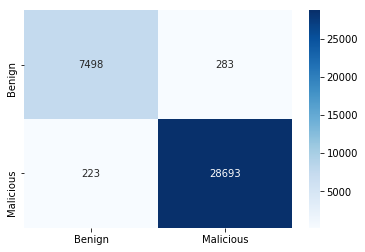

In [125]:
y=LabelEncoder().fit_transform(binary_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=['Benign', 'Malicious'],
        yticklabels=['Benign', 'Malicious'])

#### Graph of Binary Cross-Entropy Model

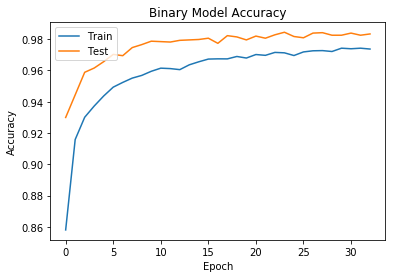

In [126]:
plotAccuracy('Binary Model Accuracy')

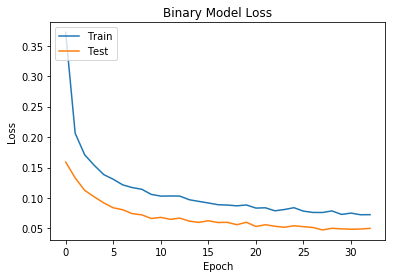

In [127]:
plotLoss('Binary Model Loss')

### Write Results to File

In [0]:
saveLog()